<a href="https://colab.research.google.com/github/joshuajhchoi/Real-Time-Voice-Cloning/blob/master/dcgan_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 복습

* 이 tutorial은 자동차 세트로 연습해본 GAN을 좀 더 가벼운 세트로 연습해보자는 뜻으로 만들었습니다. (Acknowledgement: 텐서플로우의 공식페이지의 예제와 위엠차크로운의 튜토리얼을 합하여 제작되었습니다)

* 자동차 이미지의 사이즈가 커서 너무 연습에 시간이 걸리므로 복습을 MNIST DB로 똑 같은 연습을 해보겠습니다

* 참고로 특정 GAN이 다른 GAN보다 좋다는 것은 없습니다. 대부분이 데이터세트에 좌우됩니다. 예를 들어 A모델은 DCGAN에서 잘 나왔으나 WGAN-GP에서 colapse 되고 반대로 다른 데이터 세트를 하면 WGAN-GP에서는 잘 나오나 DCGN에서 collapse될 수도 있습니다. 그래서 여러 GAN의 try 한 후 그 dataset와 가장 궁합이 잘 맞는 GAN을 찾아내는 것도 숙제입니다. 여기서 MNIST는 어느 GAN과 궁합이 잘 맞는지 보겠습니다. 첫째로 DCGAN으로 해봅니다.

* MNIST는 클래식한 머신러닝 데이터 셋으로 필기된 숫자들을 회색조로 만든 것으로 28*28 픽셀 이미지를 보고 0부터 9까지를 판별하는 용, 즉 이미지 분류의 타이타닉 같은 역할을 하는 데이터 셋입니다. 이를 GAN으로 해서 생성해 보겠습니다

* 코드의 기본 개념은 거의 같은데 데이터가 다르니 처음 데이터를 불러오고 처리하는 부분은 좀 달리 하겠습니다

* 궁극적으로 훈련 모델과 툴은 후반에 비슷하게 하여 기존에 배운 연습과 비슷하게 합니다

### 텐서플로와 다른 라이브러리 불러오기

*우선 텐서 플로우를 설치합니다

In [1]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 501kB 44.3MB/s 
     |████████████████████████████████| 4.3MB 48.3MB/s 


In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0-rc1'

In [5]:
# GIF를 만들기위해 설치합니다. https://imageio.github.io/로 가시면 더 많은 정보를 얻을 수 있습니다
!pip install imageio

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
import random
%load_ext tensorboard
from IPython import display

%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 데이터셋 로딩 및 준비
Generator와 Discriminator를 훈련하기위해 MNIST 데이터셋을 사용할것입니다. Generator는 수기 숫자 데이터를 닮은 숫자들을 생성할 것입니다. 

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 모델 만들기 
Generator와 Discriminator는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras#sequential_model)를 이용해 정의됩니다. 

### Generator

Generator는 시드값 (seed; 랜덤한 잡음, 보통 42로 많이하죠. 하지만 42로하는 특별한 이유는 없음)으로부터 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose` (업샘플링) 층을 이용합니다. 처음 `Dense`층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 `tf.keras.layers.LeakyReLU`을 사용하고 있음을 주목합시다.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 배치사이즈로 None이 주어지고 자동차 세트할 때보다 훨씬 그림이 작기 때문에 7,7,256으로 합니다

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128) #역시 사이즈가 자동차 세트보다 작지요
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64) #여기도 사이즈가 자동차 세트보다 작지요
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #역시 사이즈가 자동차 세트보다 작지요
    assert model.output_shape == (None, 28, 28, 1) #역시 사이즈가 자동차 세트보다 작지요

    return model

    # 사이즈만 빼곤 자동차 세트와 대동소이한 코드입니다

(아직 훈련이 되지않은) generator를 이용해 이미지를 생성해봅시다. 

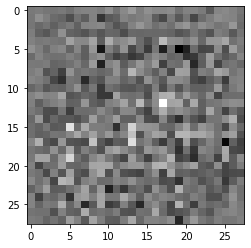

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False) # 자동차 세트에서는 training을 True로 두고 해보았는데, 여기서는 False로 해서 훈현하지 않은 상태의 모습을 보겠습니다

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator
Discriminator는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 classifier입니다. 

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

    #역시 마찬가지이나 사이즈가 다릅니다

Generator와 마찬가지로 (아직까지 훈련이 되지 않은) Discriminator를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00147305]], shape=(1, 1), dtype=float32)


## 손실함수와 옵티마이저 정의
두 모델의 손실함수와 옵티마이저를 정의합니다. 

In [15]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss Function

이 메서드는 Discriminator가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 Discriminator의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 Discriminator의 예측과 0으로 이루어진 행렬을 비교합니다.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator 손실함수
Generator의 손실함수는 Discriminator를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 Generator가 원활히 수행되고 있다면, Discriminator는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 Discriminator의 결정을 1로 이루어진 행렬과 비교를 할 것입니다.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
# Adam을 Optimizer로 사용합니다
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 체크포인트 저장
이 노트북은 오랫동안 진행되는 훈련이 방해되는 경우에 유용하게 쓰일 수 있는 모델의 저장방법과 복구방법을 보여줍니다. 

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Experiment utils (RUN ME!)

In [20]:
# 훈련 루프 정의하기

EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])
# 훈련 루프는 Generator가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. Discrimintor를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (Generator가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 Generator와 Discrimintor를 업데이트합니다.


In [21]:
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Model Traning

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [23]:
# 이미지 생성 및 저장

def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


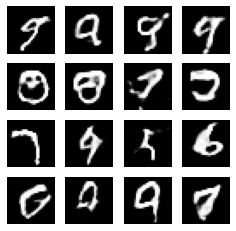

CPU times: user 3min 53s, sys: 18.1 s, total: 4min 11s
Wall time: 6min 40s


In [24]:
# 모델 훈련
# 위에 정의된 train() 메서드를 Generator와 Discrimintor를 동시에 훈련하기 위해 호출합니다. 생성적 적대 신경망을 학습하는 것은 매우 까다로울 수 있습니다. Generator와 Discrimintor가 서로를 제압하지 않는 것이 중요합니다. (예를 들어 학습률이 비슷하면 한쪽이 우세해집니다.) 훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보일 것입니다. 약 50 에포크가 지난 후, MNIST 숫자와 닮은 이미지가 생성됩니다. 코랩에서 기본 설정으로 실행하면, 에포크마다 1분정도 소요될 것입니다.
%%time
train(train_dataset, EPOCHS)

In [25]:
# 마지막 체크포인트를 복구합니다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [26]:
# GIF 생성

# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

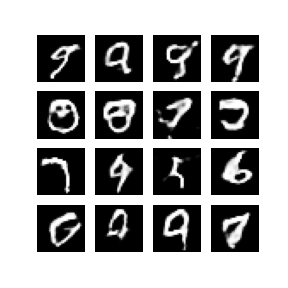

In [27]:
display_image(EPOCHS)

In [28]:
# imageio로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션을 만듭니다.

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [29]:
# 코랩에서 작업하고 있다면, 아래의 코드에서 애니메이션을 다운로드 받을 수 있습니다:

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 다음 단계

다음에는 똑 같은 DB로 WGAN을 해봅니다